# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

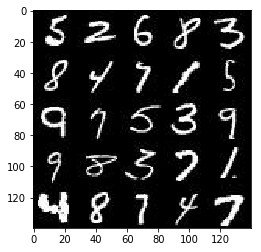

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

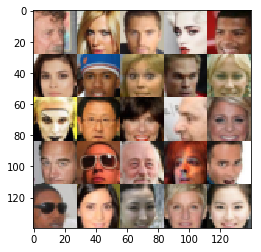

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/home/jsanchezrodr/myprojects/udacity_deep_learning/env/lib/python3.4/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    image = tf.placeholder(shape=[None,image_width, image_height, image_channels], dtype=tf.float32)
    z_input = tf.placeholder(shape=[None, z_dim], dtype=tf.float32)
    
    learning_rate = tf.placeholder(dtype=tf.float32)
    
    return image, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.4/runpy.py", line 170, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.4/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/jsanchezrodr/myprojects/udacity_deep_learning/env/lib/python3.4/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/jsanchezrodr/myprojects/udacity_deep_learning/env/lib/python3.4/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/jsanchezrodr/myprojects/udacity_deep_learning/env/lib/python3.4/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/h

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope("discriminator", reuse=reuse):
        
        
        conv1 = tf.layers.conv2d(
            inputs=images,
            filters=32,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.elu)
        
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
        
        bn1 = tf.layers.batch_normalization(pool1, training=True)
        
        
        
        conv2 = tf.layers.conv2d(
            inputs=bn1,
            filters=64,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.elu)
        
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
        
        bn2 = tf.layers.batch_normalization(pool2, training=True)
        
        
        conv3 = tf.layers.conv2d(
            inputs=bn2,
            filters=128,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.elu)
        
        pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
        
        bn3 = tf.layers.batch_normalization(pool3, training=True)
        
        a,b,c,d = bn3.get_shape()
        
        dense_input = tf.reshape(bn3, [-1,int(b*c*d)])
        logits = tf.layers.dense(dense_input,1,activation=None)
        
        output = tf.nn.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope("generator", reuse=not is_train):
        
        
        dense1 = tf.layers.dense(z, 128*7*7, tf.nn.elu)
        
        
        dense1_block = tf.reshape(dense1, [-1,7,7,128])
        
        dense_bn = tf.layers.batch_normalization(dense1_block, training=is_train)
        
        convt1 = tf.layers.conv2d_transpose(
            inputs=dense_bn,
            filters=64,
            kernel_size=[5,5],
            strides=1,
            padding="same",
            activation=tf.nn.elu
        )
        
        convt1_bn = tf.layers.batch_normalization(convt1, training=is_train)
        
        
        convt2 = tf.layers.conv2d_transpose(
            inputs=convt1_bn,
            filters=32,
            kernel_size=[5,5],
            strides=2,
            padding="same",
            activation=tf.nn.elu
        )
        
        convt2_bn = tf.layers.batch_normalization(convt2, training=is_train)
        
        
        convt3 = tf.layers.conv2d_transpose(
            inputs=convt2_bn,
            filters=out_channel_dim,
            kernel_size=[5,5],
            strides=2,
            padding="same",
            activation=tf.nn.tanh,
        )
        
        output = convt3
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    
    output_real, logits_real = discriminator(input_real, reuse=False)    
    
    input_fake = generator(input_z, out_channel_dim, is_train=True) # reuse=False
    output_fake, logits_fake = discriminator(input_fake, reuse=True)
    
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=tf.ones_like(output_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.zeros_like(output_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.ones_like(output_fake)))

    return d_loss, g_loss
    
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    #From DCGAN
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    #print(beta1)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
import matplotlib.pyplot as plt
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    data_size,image_width,image_height,image_channels =  data_shape
    image_placeholder, z_placeholder, lr_placeholder = model_inputs(image_width, image_height,image_channels, z_dim)
    
    n_images_show =25
    show_every=100
    print_every = 10
    
    
    d_loss, g_loss = model_loss(image_placeholder, z_placeholder,image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr_placeholder, beta1)
    
    losses = []
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={
                    image_placeholder: batch_images, 
                    z_placeholder: batch_z,
                    lr_placeholder:learning_rate
                })
                
                _ = sess.run(g_train_opt, feed_dict={
                    image_placeholder: batch_images,
                    z_placeholder: batch_z,
                    lr_placeholder:learning_rate
                })

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({
                        z_placeholder: batch_z, 
                        image_placeholder: batch_images,
                        lr_placeholder:learning_rate
                    })
                    train_loss_g = g_loss.eval({
                        z_placeholder: batch_z,
                        lr_placeholder:learning_rate,
                        image_placeholder: batch_images,
                    })

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if(steps%show_every == 0):
                    show_generator_output(sess,n_images_show,z_placeholder,image_channels,data_image_mode)
                steps += 1

        show_generator_output(sess,n_images_show,z_placeholder,image_channels,data_image_mode)
        fig, ax = plt.subplots()
        losses = np.array(losses)
        plt.plot(losses.T[0], label='Discriminator')
        plt.plot(losses.T[1], label='Generator')
        plt.title("Training Losses")
        plt.legend()
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 5.9766... Generator Loss: 0.0054


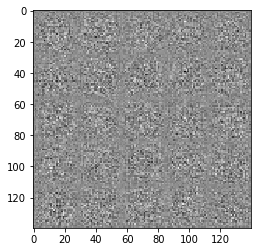

Epoch 1/2... Discriminator Loss: 1.1700... Generator Loss: 0.7657
Epoch 1/2... Discriminator Loss: 0.5521... Generator Loss: 1.6793
Epoch 1/2... Discriminator Loss: 0.2445... Generator Loss: 2.1017
Epoch 1/2... Discriminator Loss: 0.0747... Generator Loss: 3.1922
Epoch 1/2... Discriminator Loss: 0.0930... Generator Loss: 2.9351
Epoch 1/2... Discriminator Loss: 0.0965... Generator Loss: 2.9281
Epoch 1/2... Discriminator Loss: 0.2650... Generator Loss: 2.0997
Epoch 1/2... Discriminator Loss: 0.6259... Generator Loss: 1.1336
Epoch 1/2... Discriminator Loss: 0.5093... Generator Loss: 1.2801
Epoch 1/2... Discriminator Loss: 0.8271... Generator Loss: 1.0378


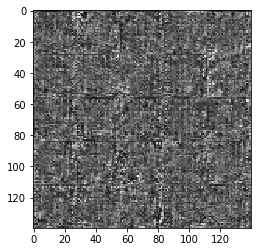

Epoch 1/2... Discriminator Loss: 0.7172... Generator Loss: 0.9516
Epoch 1/2... Discriminator Loss: 0.3276... Generator Loss: 1.8058
Epoch 1/2... Discriminator Loss: 0.3522... Generator Loss: 1.6677
Epoch 1/2... Discriminator Loss: 0.2735... Generator Loss: 2.0422
Epoch 1/2... Discriminator Loss: 1.1749... Generator Loss: 1.7767
Epoch 1/2... Discriminator Loss: 0.3337... Generator Loss: 1.7892
Epoch 1/2... Discriminator Loss: 0.4423... Generator Loss: 4.1285
Epoch 1/2... Discriminator Loss: 0.3830... Generator Loss: 1.6176
Epoch 1/2... Discriminator Loss: 0.2606... Generator Loss: 2.6926
Epoch 1/2... Discriminator Loss: 0.9303... Generator Loss: 0.6808


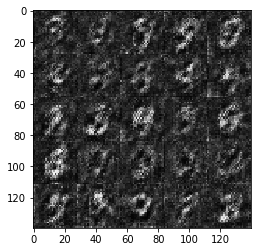

Epoch 1/2... Discriminator Loss: 0.5703... Generator Loss: 1.6060
Epoch 1/2... Discriminator Loss: 0.3035... Generator Loss: 2.3946
Epoch 1/2... Discriminator Loss: 0.3732... Generator Loss: 1.9020
Epoch 1/2... Discriminator Loss: 0.3969... Generator Loss: 1.6710
Epoch 1/2... Discriminator Loss: 0.5647... Generator Loss: 1.5345
Epoch 1/2... Discriminator Loss: 0.3323... Generator Loss: 1.9037
Epoch 1/2... Discriminator Loss: 0.3833... Generator Loss: 1.5705
Epoch 1/2... Discriminator Loss: 1.3045... Generator Loss: 5.7305
Epoch 1/2... Discriminator Loss: 0.3545... Generator Loss: 1.6682
Epoch 1/2... Discriminator Loss: 0.2649... Generator Loss: 2.4404


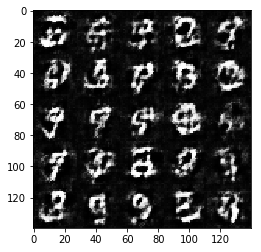

Epoch 1/2... Discriminator Loss: 0.7557... Generator Loss: 0.8683
Epoch 1/2... Discriminator Loss: 0.3222... Generator Loss: 2.0009
Epoch 1/2... Discriminator Loss: 1.0273... Generator Loss: 0.6650
Epoch 1/2... Discriminator Loss: 0.2635... Generator Loss: 2.8264
Epoch 1/2... Discriminator Loss: 0.3727... Generator Loss: 2.3511
Epoch 1/2... Discriminator Loss: 0.6326... Generator Loss: 4.3896
Epoch 1/2... Discriminator Loss: 0.3297... Generator Loss: 2.0235
Epoch 1/2... Discriminator Loss: 0.3078... Generator Loss: 2.1943
Epoch 1/2... Discriminator Loss: 0.3244... Generator Loss: 1.8705
Epoch 1/2... Discriminator Loss: 0.2150... Generator Loss: 3.0024


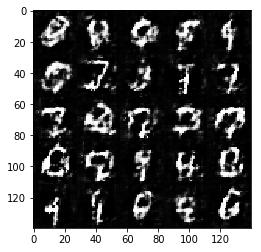

Epoch 1/2... Discriminator Loss: 0.6642... Generator Loss: 1.1350
Epoch 1/2... Discriminator Loss: 2.4454... Generator Loss: 0.3193
Epoch 1/2... Discriminator Loss: 0.7840... Generator Loss: 4.1954
Epoch 1/2... Discriminator Loss: 0.3102... Generator Loss: 1.9073
Epoch 1/2... Discriminator Loss: 0.5635... Generator Loss: 1.2389
Epoch 1/2... Discriminator Loss: 0.4205... Generator Loss: 1.8115
Epoch 1/2... Discriminator Loss: 0.3494... Generator Loss: 2.1765
Epoch 1/2... Discriminator Loss: 1.3208... Generator Loss: 5.7449
Epoch 1/2... Discriminator Loss: 0.4323... Generator Loss: 1.5416
Epoch 1/2... Discriminator Loss: 0.6317... Generator Loss: 1.3360


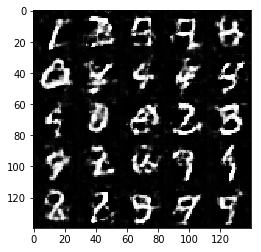

Epoch 1/2... Discriminator Loss: 0.6421... Generator Loss: 1.1331
Epoch 1/2... Discriminator Loss: 0.4728... Generator Loss: 3.0298
Epoch 1/2... Discriminator Loss: 0.4993... Generator Loss: 1.5784
Epoch 1/2... Discriminator Loss: 0.4852... Generator Loss: 1.3609
Epoch 1/2... Discriminator Loss: 0.6473... Generator Loss: 1.1210
Epoch 1/2... Discriminator Loss: 0.4411... Generator Loss: 1.5641
Epoch 1/2... Discriminator Loss: 0.6152... Generator Loss: 3.0765
Epoch 1/2... Discriminator Loss: 0.5034... Generator Loss: 1.3584
Epoch 1/2... Discriminator Loss: 0.4212... Generator Loss: 1.7063
Epoch 1/2... Discriminator Loss: 0.4856... Generator Loss: 2.2076


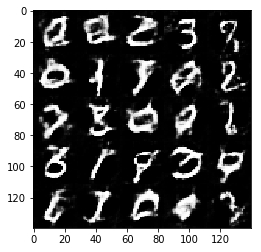

Epoch 1/2... Discriminator Loss: 0.6494... Generator Loss: 1.0748
Epoch 1/2... Discriminator Loss: 0.5678... Generator Loss: 1.3952
Epoch 1/2... Discriminator Loss: 0.4463... Generator Loss: 2.8215
Epoch 1/2... Discriminator Loss: 0.8461... Generator Loss: 0.8475
Epoch 1/2... Discriminator Loss: 0.5606... Generator Loss: 1.4080
Epoch 1/2... Discriminator Loss: 0.3837... Generator Loss: 2.2942
Epoch 1/2... Discriminator Loss: 0.4311... Generator Loss: 1.6787
Epoch 1/2... Discriminator Loss: 0.6210... Generator Loss: 1.4060
Epoch 1/2... Discriminator Loss: 0.3926... Generator Loss: 1.7533
Epoch 1/2... Discriminator Loss: 0.4471... Generator Loss: 1.6597


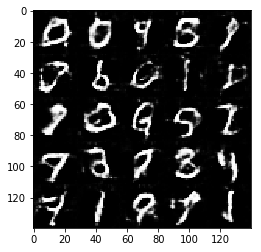

Epoch 1/2... Discriminator Loss: 1.1370... Generator Loss: 0.5240
Epoch 1/2... Discriminator Loss: 0.6160... Generator Loss: 1.0908
Epoch 1/2... Discriminator Loss: 0.3202... Generator Loss: 2.3816
Epoch 1/2... Discriminator Loss: 0.4197... Generator Loss: 1.5979
Epoch 1/2... Discriminator Loss: 0.3663... Generator Loss: 2.2261
Epoch 1/2... Discriminator Loss: 0.5167... Generator Loss: 1.5526
Epoch 1/2... Discriminator Loss: 0.7029... Generator Loss: 2.0771
Epoch 1/2... Discriminator Loss: 0.5151... Generator Loss: 1.3324
Epoch 1/2... Discriminator Loss: 0.3570... Generator Loss: 1.9510
Epoch 1/2... Discriminator Loss: 0.6793... Generator Loss: 1.0023


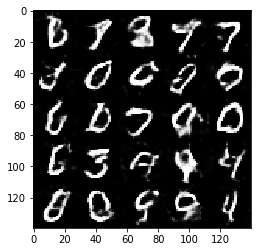

Epoch 1/2... Discriminator Loss: 1.5182... Generator Loss: 0.3884
Epoch 1/2... Discriminator Loss: 0.5268... Generator Loss: 1.5430
Epoch 1/2... Discriminator Loss: 0.5887... Generator Loss: 1.2734
Epoch 1/2... Discriminator Loss: 0.3933... Generator Loss: 1.5003
Epoch 1/2... Discriminator Loss: 0.5367... Generator Loss: 1.2476
Epoch 1/2... Discriminator Loss: 0.5480... Generator Loss: 1.4515
Epoch 1/2... Discriminator Loss: 0.4991... Generator Loss: 1.3739
Epoch 1/2... Discriminator Loss: 0.4442... Generator Loss: 2.1627
Epoch 1/2... Discriminator Loss: 0.7257... Generator Loss: 0.9717
Epoch 1/2... Discriminator Loss: 0.6270... Generator Loss: 1.1284


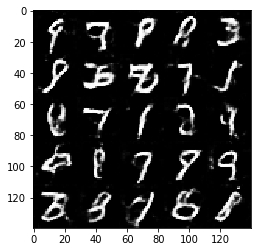

Epoch 1/2... Discriminator Loss: 0.4799... Generator Loss: 1.4242
Epoch 1/2... Discriminator Loss: 0.5720... Generator Loss: 1.3865
Epoch 1/2... Discriminator Loss: 1.6224... Generator Loss: 0.3779
Epoch 2/2... Discriminator Loss: 0.4523... Generator Loss: 1.5755
Epoch 2/2... Discriminator Loss: 0.4163... Generator Loss: 1.5778
Epoch 2/2... Discriminator Loss: 0.4376... Generator Loss: 2.0939
Epoch 2/2... Discriminator Loss: 0.7651... Generator Loss: 0.8824
Epoch 2/2... Discriminator Loss: 0.9331... Generator Loss: 0.7921
Epoch 2/2... Discriminator Loss: 0.5342... Generator Loss: 1.5478
Epoch 2/2... Discriminator Loss: 0.5181... Generator Loss: 1.2985


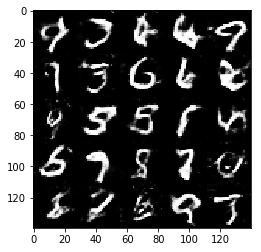

Epoch 2/2... Discriminator Loss: 0.4385... Generator Loss: 2.0560
Epoch 2/2... Discriminator Loss: 0.4565... Generator Loss: 1.7011
Epoch 2/2... Discriminator Loss: 0.5656... Generator Loss: 1.1345
Epoch 2/2... Discriminator Loss: 0.7666... Generator Loss: 1.0241
Epoch 2/2... Discriminator Loss: 0.4988... Generator Loss: 1.2999
Epoch 2/2... Discriminator Loss: 0.4995... Generator Loss: 1.5775
Epoch 2/2... Discriminator Loss: 0.6405... Generator Loss: 1.3559
Epoch 2/2... Discriminator Loss: 0.5863... Generator Loss: 1.2267
Epoch 2/2... Discriminator Loss: 0.6085... Generator Loss: 1.2563
Epoch 2/2... Discriminator Loss: 0.5787... Generator Loss: 1.2522


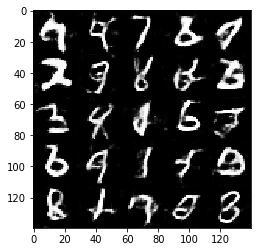

Epoch 2/2... Discriminator Loss: 0.6957... Generator Loss: 1.1410
Epoch 2/2... Discriminator Loss: 0.9019... Generator Loss: 0.7904
Epoch 2/2... Discriminator Loss: 1.4342... Generator Loss: 0.4152
Epoch 2/2... Discriminator Loss: 0.7424... Generator Loss: 0.9477
Epoch 2/2... Discriminator Loss: 0.4470... Generator Loss: 1.5675
Epoch 2/2... Discriminator Loss: 0.5216... Generator Loss: 1.3991
Epoch 2/2... Discriminator Loss: 0.4208... Generator Loss: 1.6922
Epoch 2/2... Discriminator Loss: 0.6098... Generator Loss: 3.2375
Epoch 2/2... Discriminator Loss: 1.6048... Generator Loss: 0.3553
Epoch 2/2... Discriminator Loss: 0.4041... Generator Loss: 1.8335


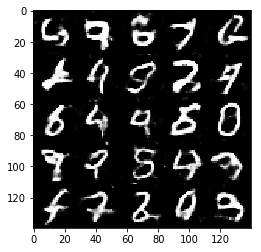

Epoch 2/2... Discriminator Loss: 0.8779... Generator Loss: 0.9308
Epoch 2/2... Discriminator Loss: 0.4323... Generator Loss: 1.8646
Epoch 2/2... Discriminator Loss: 0.8660... Generator Loss: 0.8160
Epoch 2/2... Discriminator Loss: 0.6159... Generator Loss: 1.3601
Epoch 2/2... Discriminator Loss: 0.5779... Generator Loss: 1.2102
Epoch 2/2... Discriminator Loss: 0.7870... Generator Loss: 0.8472
Epoch 2/2... Discriminator Loss: 0.8164... Generator Loss: 0.8920
Epoch 2/2... Discriminator Loss: 0.3577... Generator Loss: 2.0107
Epoch 2/2... Discriminator Loss: 0.7885... Generator Loss: 3.3060
Epoch 2/2... Discriminator Loss: 0.9021... Generator Loss: 0.7375


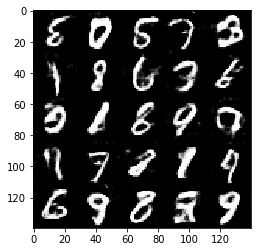

Epoch 2/2... Discriminator Loss: 0.5699... Generator Loss: 1.3259
Epoch 2/2... Discriminator Loss: 0.7400... Generator Loss: 0.9640
Epoch 2/2... Discriminator Loss: 1.8372... Generator Loss: 4.7633
Epoch 2/2... Discriminator Loss: 0.5255... Generator Loss: 1.7190
Epoch 2/2... Discriminator Loss: 1.1523... Generator Loss: 0.6096
Epoch 2/2... Discriminator Loss: 0.4723... Generator Loss: 1.4148
Epoch 2/2... Discriminator Loss: 0.4841... Generator Loss: 1.5724
Epoch 2/2... Discriminator Loss: 0.9880... Generator Loss: 0.6379
Epoch 2/2... Discriminator Loss: 1.9249... Generator Loss: 0.2385
Epoch 2/2... Discriminator Loss: 0.5009... Generator Loss: 1.3413


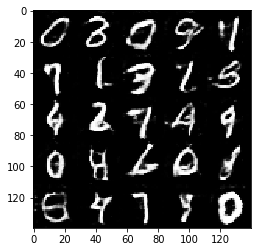

Epoch 2/2... Discriminator Loss: 0.3258... Generator Loss: 2.1058
Epoch 2/2... Discriminator Loss: 0.6675... Generator Loss: 1.0686
Epoch 2/2... Discriminator Loss: 0.4004... Generator Loss: 1.7850
Epoch 2/2... Discriminator Loss: 0.4399... Generator Loss: 1.6049
Epoch 2/2... Discriminator Loss: 0.7161... Generator Loss: 0.9786
Epoch 2/2... Discriminator Loss: 0.3490... Generator Loss: 2.0627
Epoch 2/2... Discriminator Loss: 0.8475... Generator Loss: 0.8385
Epoch 2/2... Discriminator Loss: 0.4476... Generator Loss: 1.5292
Epoch 2/2... Discriminator Loss: 1.2957... Generator Loss: 0.4996
Epoch 2/2... Discriminator Loss: 1.6775... Generator Loss: 0.3877


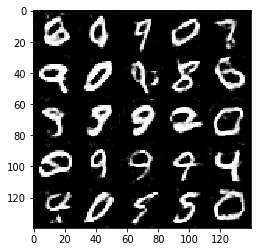

Epoch 2/2... Discriminator Loss: 1.1266... Generator Loss: 0.5653
Epoch 2/2... Discriminator Loss: 0.3138... Generator Loss: 2.2067
Epoch 2/2... Discriminator Loss: 1.9370... Generator Loss: 0.2728
Epoch 2/2... Discriminator Loss: 0.4403... Generator Loss: 1.6155
Epoch 2/2... Discriminator Loss: 0.6116... Generator Loss: 1.1035
Epoch 2/2... Discriminator Loss: 0.8135... Generator Loss: 1.0265
Epoch 2/2... Discriminator Loss: 0.5803... Generator Loss: 1.2757
Epoch 2/2... Discriminator Loss: 0.7845... Generator Loss: 0.9262
Epoch 2/2... Discriminator Loss: 0.4443... Generator Loss: 1.5808
Epoch 2/2... Discriminator Loss: 0.5700... Generator Loss: 1.3691


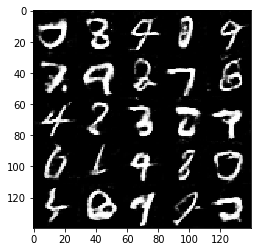

Epoch 2/2... Discriminator Loss: 0.6750... Generator Loss: 1.0718
Epoch 2/2... Discriminator Loss: 0.5397... Generator Loss: 1.3958
Epoch 2/2... Discriminator Loss: 0.7117... Generator Loss: 1.0541
Epoch 2/2... Discriminator Loss: 0.5083... Generator Loss: 1.2823
Epoch 2/2... Discriminator Loss: 0.4877... Generator Loss: 1.5786
Epoch 2/2... Discriminator Loss: 0.4148... Generator Loss: 1.9763
Epoch 2/2... Discriminator Loss: 0.5110... Generator Loss: 1.4033
Epoch 2/2... Discriminator Loss: 0.4901... Generator Loss: 1.2981
Epoch 2/2... Discriminator Loss: 0.7658... Generator Loss: 0.9620
Epoch 2/2... Discriminator Loss: 0.3923... Generator Loss: 1.5095


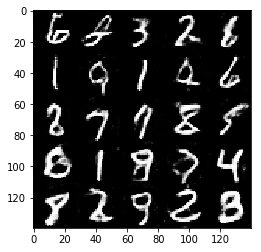

Epoch 2/2... Discriminator Loss: 0.7739... Generator Loss: 0.9395
Epoch 2/2... Discriminator Loss: 4.4110... Generator Loss: 7.4143
Epoch 2/2... Discriminator Loss: 0.5280... Generator Loss: 1.4146
Epoch 2/2... Discriminator Loss: 0.4600... Generator Loss: 1.7283
Epoch 2/2... Discriminator Loss: 0.7000... Generator Loss: 1.1712
Epoch 2/2... Discriminator Loss: 1.0934... Generator Loss: 0.6163
Epoch 2/2... Discriminator Loss: 0.5779... Generator Loss: 1.4716
Epoch 2/2... Discriminator Loss: 0.7877... Generator Loss: 0.9442
Epoch 2/2... Discriminator Loss: 0.8860... Generator Loss: 0.7765
Epoch 2/2... Discriminator Loss: 0.6092... Generator Loss: 1.1092


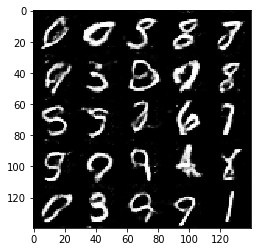

Epoch 2/2... Discriminator Loss: 0.5854... Generator Loss: 1.1540
Epoch 2/2... Discriminator Loss: 0.6792... Generator Loss: 1.1590
Epoch 2/2... Discriminator Loss: 0.5170... Generator Loss: 3.4393
Epoch 2/2... Discriminator Loss: 0.7048... Generator Loss: 1.0597
Epoch 2/2... Discriminator Loss: 0.5300... Generator Loss: 1.3914
Epoch 2/2... Discriminator Loss: 0.3795... Generator Loss: 2.0084
Epoch 2/2... Discriminator Loss: 0.6735... Generator Loss: 1.0594


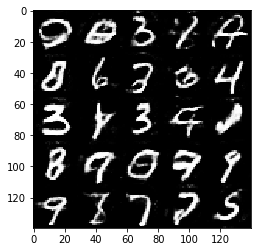

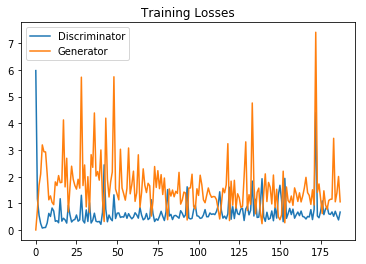

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 5e-4
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.5025... Generator Loss: 0.0235


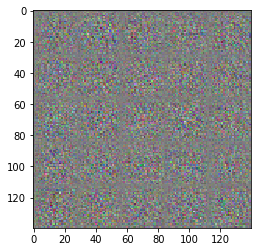

Epoch 1/1... Discriminator Loss: 2.2472... Generator Loss: 0.3095
Epoch 1/1... Discriminator Loss: 1.5757... Generator Loss: 0.4783
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 1.6575
Epoch 1/1... Discriminator Loss: 0.7209... Generator Loss: 1.0803
Epoch 1/1... Discriminator Loss: 0.5837... Generator Loss: 1.5343
Epoch 1/1... Discriminator Loss: 0.1825... Generator Loss: 2.9475
Epoch 1/1... Discriminator Loss: 0.1726... Generator Loss: 2.8879
Epoch 1/1... Discriminator Loss: 0.0798... Generator Loss: 3.4823
Epoch 1/1... Discriminator Loss: 0.2755... Generator Loss: 2.2630
Epoch 1/1... Discriminator Loss: 0.2700... Generator Loss: 2.9547


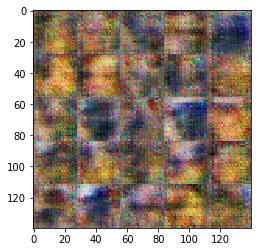

Epoch 1/1... Discriminator Loss: 0.8639... Generator Loss: 1.0523
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 1.1910
Epoch 1/1... Discriminator Loss: 0.3917... Generator Loss: 1.6587
Epoch 1/1... Discriminator Loss: 0.6451... Generator Loss: 4.7726
Epoch 1/1... Discriminator Loss: 0.4607... Generator Loss: 1.6444
Epoch 1/1... Discriminator Loss: 0.4210... Generator Loss: 2.3575
Epoch 1/1... Discriminator Loss: 0.2725... Generator Loss: 2.3608
Epoch 1/1... Discriminator Loss: 0.2067... Generator Loss: 2.2397
Epoch 1/1... Discriminator Loss: 2.0113... Generator Loss: 6.1098
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 3.2019


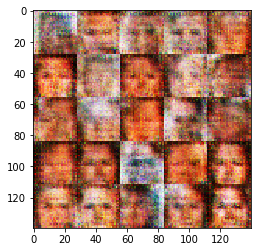

Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 0.7372... Generator Loss: 1.0452
Epoch 1/1... Discriminator Loss: 0.9156... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 0.5255... Generator Loss: 1.4566
Epoch 1/1... Discriminator Loss: 0.7775... Generator Loss: 1.4795
Epoch 1/1... Discriminator Loss: 1.7851... Generator Loss: 2.6546
Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 0.4777... Generator Loss: 1.8270
Epoch 1/1... Discriminator Loss: 0.5069... Generator Loss: 2.2045
Epoch 1/1... Discriminator Loss: 0.5554... Generator Loss: 1.7350


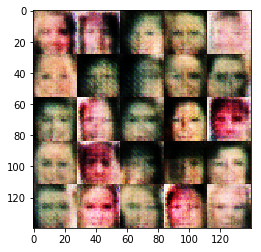

Epoch 1/1... Discriminator Loss: 0.7424... Generator Loss: 1.0157
Epoch 1/1... Discriminator Loss: 0.6818... Generator Loss: 1.2307
Epoch 1/1... Discriminator Loss: 0.6664... Generator Loss: 1.2689
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.5449
Epoch 1/1... Discriminator Loss: 1.9017... Generator Loss: 0.2675
Epoch 1/1... Discriminator Loss: 0.5783... Generator Loss: 2.2760
Epoch 1/1... Discriminator Loss: 0.8885... Generator Loss: 2.2734
Epoch 1/1... Discriminator Loss: 0.6935... Generator Loss: 2.2380
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 0.9943
Epoch 1/1... Discriminator Loss: 0.7540... Generator Loss: 1.4501


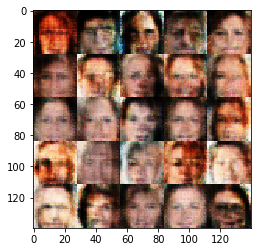

Epoch 1/1... Discriminator Loss: 0.8011... Generator Loss: 1.0704
Epoch 1/1... Discriminator Loss: 0.8361... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 1.5875
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 1.0034
Epoch 1/1... Discriminator Loss: 0.7148... Generator Loss: 1.7916
Epoch 1/1... Discriminator Loss: 0.9942... Generator Loss: 2.4937
Epoch 1/1... Discriminator Loss: 0.7850... Generator Loss: 1.1248
Epoch 1/1... Discriminator Loss: 2.2707... Generator Loss: 3.7288
Epoch 1/1... Discriminator Loss: 0.6854... Generator Loss: 1.2437
Epoch 1/1... Discriminator Loss: 0.7111... Generator Loss: 2.6990


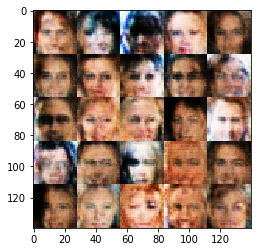

Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 0.8551
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.4759
Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 2.4281
Epoch 1/1... Discriminator Loss: 0.6549... Generator Loss: 1.5473
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 2.3719
Epoch 1/1... Discriminator Loss: 0.4375... Generator Loss: 2.0379
Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 0.9243
Epoch 1/1... Discriminator Loss: 0.7827... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 0.7434... Generator Loss: 1.2008


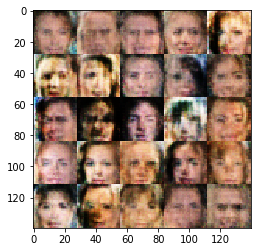

Epoch 1/1... Discriminator Loss: 0.7999... Generator Loss: 1.2302
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 1.0915
Epoch 1/1... Discriminator Loss: 0.9751... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 0.9794
Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 1.9155
Epoch 1/1... Discriminator Loss: 0.8463... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 0.8016... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 0.9125... Generator Loss: 0.8320


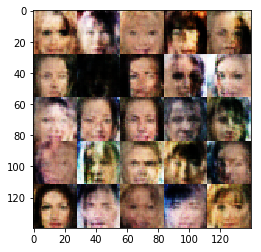

Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.3848
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 1.1061
Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 1.7061
Epoch 1/1... Discriminator Loss: 1.6294... Generator Loss: 0.2737
Epoch 1/1... Discriminator Loss: 0.5818... Generator Loss: 1.6837
Epoch 1/1... Discriminator Loss: 0.7740... Generator Loss: 0.9693
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 2.7042
Epoch 1/1... Discriminator Loss: 1.0337... Generator Loss: 0.6070


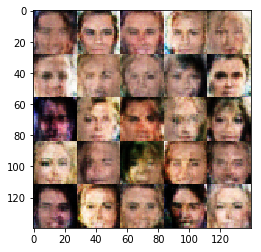

Epoch 1/1... Discriminator Loss: 0.6722... Generator Loss: 1.0244
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.3687
Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 0.6018
Epoch 1/1... Discriminator Loss: 0.5775... Generator Loss: 1.9007
Epoch 1/1... Discriminator Loss: 0.8611... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 3.4942
Epoch 1/1... Discriminator Loss: 0.6245... Generator Loss: 1.4589
Epoch 1/1... Discriminator Loss: 0.5986... Generator Loss: 1.5306
Epoch 1/1... Discriminator Loss: 0.8419... Generator Loss: 0.9258


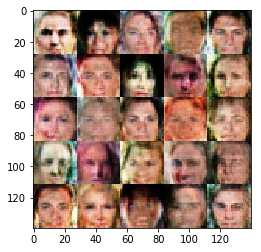

Epoch 1/1... Discriminator Loss: 0.6232... Generator Loss: 1.7692
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 0.8293... Generator Loss: 1.2575
Epoch 1/1... Discriminator Loss: 0.7515... Generator Loss: 1.1450
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.5246
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 2.4118
Epoch 1/1... Discriminator Loss: 0.8008... Generator Loss: 0.9622
Epoch 1/1... Discriminator Loss: 0.7834... Generator Loss: 1.0447
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.5595


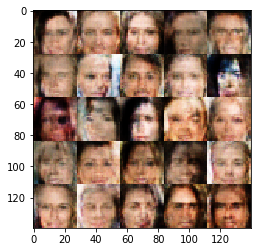

Epoch 1/1... Discriminator Loss: 0.8080... Generator Loss: 1.6881
Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 1.0455... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.4608
Epoch 1/1... Discriminator Loss: 0.5733... Generator Loss: 1.8344
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.4423
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.3762
Epoch 1/1... Discriminator Loss: 0.6940... Generator Loss: 1.2970
Epoch 1/1... Discriminator Loss: 0.9233... Generator Loss: 1.5357


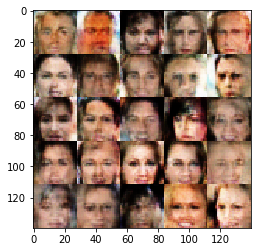

Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 2.5239
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 1.6587
Epoch 1/1... Discriminator Loss: 0.8325... Generator Loss: 1.1788
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.5627
Epoch 1/1... Discriminator Loss: 0.8347... Generator Loss: 1.5412
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.5516
Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 0.8903... Generator Loss: 1.1667


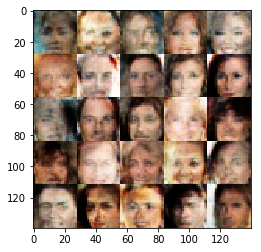

Epoch 1/1... Discriminator Loss: 0.7742... Generator Loss: 1.1466
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 1.5572
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 0.7432... Generator Loss: 1.5431
Epoch 1/1... Discriminator Loss: 0.9354... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 1.0945
Epoch 1/1... Discriminator Loss: 0.8895... Generator Loss: 1.8267
Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 1.7993... Generator Loss: 0.2274


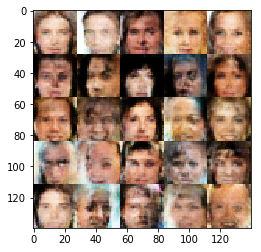

Epoch 1/1... Discriminator Loss: 0.9347... Generator Loss: 1.7445
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.4751
Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 0.9241... Generator Loss: 0.9226
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: 0.8320... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 0.9052... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 2.5546


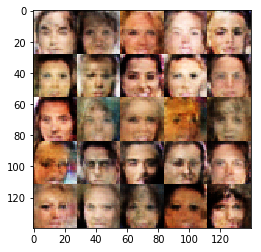

Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 2.4931
Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.4439
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.5644
Epoch 1/1... Discriminator Loss: 0.7290... Generator Loss: 1.2825
Epoch 1/1... Discriminator Loss: 1.5051... Generator Loss: 0.3415
Epoch 1/1... Discriminator Loss: 0.8328... Generator Loss: 0.8671
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 0.9347
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.6157


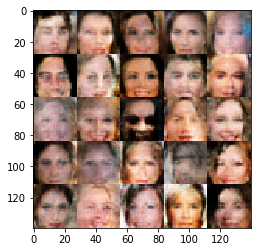

Epoch 1/1... Discriminator Loss: 0.6245... Generator Loss: 1.5157
Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 0.7093... Generator Loss: 1.1575
Epoch 1/1... Discriminator Loss: 0.8439... Generator Loss: 1.5057
Epoch 1/1... Discriminator Loss: 0.7644... Generator Loss: 2.0633
Epoch 1/1... Discriminator Loss: 0.9304... Generator Loss: 1.0565
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.4175
Epoch 1/1... Discriminator Loss: 0.6966... Generator Loss: 1.1155
Epoch 1/1... Discriminator Loss: 0.8631... Generator Loss: 0.9151


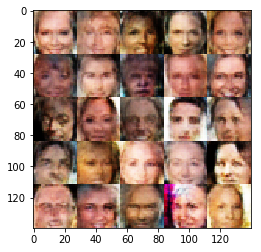

Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.4652
Epoch 1/1... Discriminator Loss: 0.9267... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 0.6778... Generator Loss: 1.2016
Epoch 1/1... Discriminator Loss: 0.7130... Generator Loss: 1.3114
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 0.5248
Epoch 1/1... Discriminator Loss: 0.8368... Generator Loss: 1.3110
Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 0.9482
Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 1.1066
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 0.7548


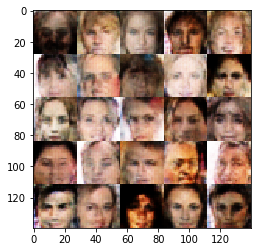

Epoch 1/1... Discriminator Loss: 0.7825... Generator Loss: 1.4537
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 0.8353... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.5964... Generator Loss: 0.2948
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.5062
Epoch 1/1... Discriminator Loss: 0.8480... Generator Loss: 0.9623
Epoch 1/1... Discriminator Loss: 0.6894... Generator Loss: 1.1890
Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.5286
Epoch 1/1... Discriminator Loss: 0.8829... Generator Loss: 1.0763


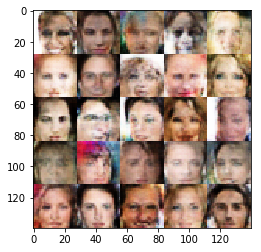

Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.4016
Epoch 1/1... Discriminator Loss: 0.8929... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 0.9731... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 0.8981... Generator Loss: 0.9818
Epoch 1/1... Discriminator Loss: 1.7598... Generator Loss: 0.2544
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 2.1331
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 0.8554... Generator Loss: 1.1902


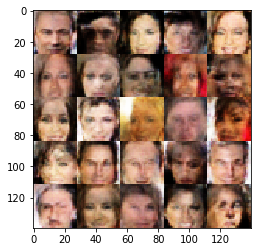

Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 0.8643... Generator Loss: 2.4736
Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 0.7345... Generator Loss: 1.3000
Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.3590
Epoch 1/1... Discriminator Loss: 0.7560... Generator Loss: 1.5967
Epoch 1/1... Discriminator Loss: 0.9430... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 0.8990... Generator Loss: 0.9678


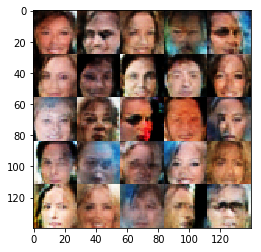

Epoch 1/1... Discriminator Loss: 0.8552... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 0.8952... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.3989
Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 1.1924
Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.5360
Epoch 1/1... Discriminator Loss: 0.8266... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.4914
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 0.8136... Generator Loss: 1.5570


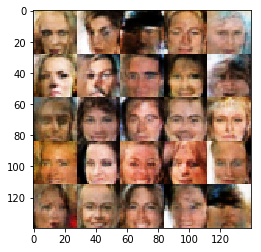

Epoch 1/1... Discriminator Loss: 0.8673... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 0.7258... Generator Loss: 1.0816
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.4002
Epoch 1/1... Discriminator Loss: 0.8695... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 2.5825
Epoch 1/1... Discriminator Loss: 0.9886... Generator Loss: 2.4109
Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 0.7313... Generator Loss: 1.2131
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 1.6990


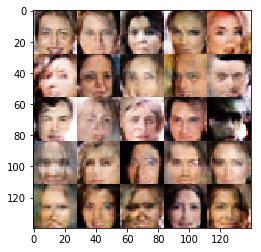

Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 1.3648
Epoch 1/1... Discriminator Loss: 1.5822... Generator Loss: 0.2965
Epoch 1/1... Discriminator Loss: 0.8773... Generator Loss: 1.7153
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 0.8081... Generator Loss: 1.7617
Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 0.8651... Generator Loss: 1.8268
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 0.5625


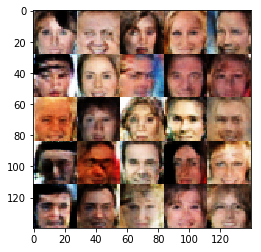

Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 0.8982... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 0.9942... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 1.9200
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 0.9325... Generator Loss: 1.6347
Epoch 1/1... Discriminator Loss: 0.8077... Generator Loss: 1.3298
Epoch 1/1... Discriminator Loss: 0.9495... Generator Loss: 0.7656


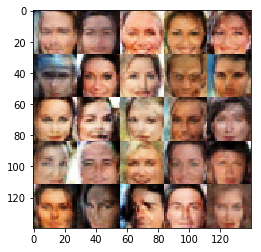

Epoch 1/1... Discriminator Loss: 0.9344... Generator Loss: 1.5224
Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 1.4409
Epoch 1/1... Discriminator Loss: 0.7215... Generator Loss: 1.0848
Epoch 1/1... Discriminator Loss: 0.8367... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 0.7572... Generator Loss: 1.1130
Epoch 1/1... Discriminator Loss: 0.8900... Generator Loss: 1.0146
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 0.5685
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 0.8875... Generator Loss: 0.8043


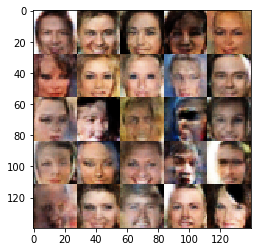

Epoch 1/1... Discriminator Loss: 0.9065... Generator Loss: 0.9226
Epoch 1/1... Discriminator Loss: 0.7757... Generator Loss: 1.0270
Epoch 1/1... Discriminator Loss: 0.8526... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 0.7093... Generator Loss: 1.1448
Epoch 1/1... Discriminator Loss: 0.8735... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 0.7510... Generator Loss: 1.6603
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 1.4910
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.3799
Epoch 1/1... Discriminator Loss: 0.8991... Generator Loss: 0.8261


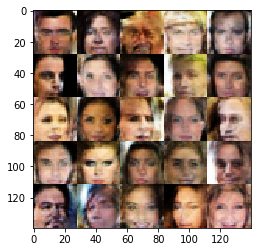

Epoch 1/1... Discriminator Loss: 0.9075... Generator Loss: 0.9369
Epoch 1/1... Discriminator Loss: 0.8143... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.4363
Epoch 1/1... Discriminator Loss: 0.7297... Generator Loss: 1.1848
Epoch 1/1... Discriminator Loss: 0.7715... Generator Loss: 1.2645
Epoch 1/1... Discriminator Loss: 0.6805... Generator Loss: 1.3860
Epoch 1/1... Discriminator Loss: 0.8326... Generator Loss: 1.1036
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.4775
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 2.7360
Epoch 1/1... Discriminator Loss: 0.7609... Generator Loss: 1.1083


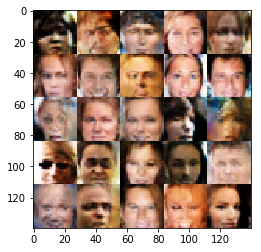

Epoch 1/1... Discriminator Loss: 0.6888... Generator Loss: 1.2040
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.5022
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 1.2516
Epoch 1/1... Discriminator Loss: 0.9212... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 0.7666... Generator Loss: 1.3249
Epoch 1/1... Discriminator Loss: 0.9141... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 0.9472... Generator Loss: 0.8785
Epoch 1/1... Discriminator Loss: 0.7010... Generator Loss: 1.1801
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.4765
Epoch 1/1... Discriminator Loss: 0.8697... Generator Loss: 0.8371


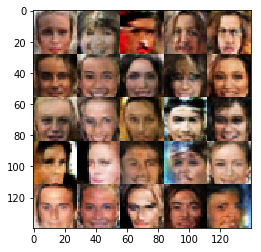

Epoch 1/1... Discriminator Loss: 0.7621... Generator Loss: 1.0335
Epoch 1/1... Discriminator Loss: 0.8452... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 1.2153
Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 0.9258
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 0.9354... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.4465
Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 2.1533
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.4713


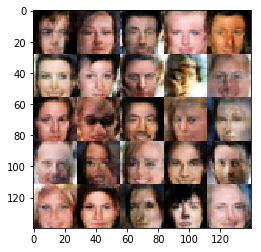

Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.5029
Epoch 1/1... Discriminator Loss: 0.8339... Generator Loss: 1.2478
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 0.6092... Generator Loss: 1.2043
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.5466... Generator Loss: 0.3558
Epoch 1/1... Discriminator Loss: 0.7055... Generator Loss: 1.2793
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.5092
Epoch 1/1... Discriminator Loss: 0.9370... Generator Loss: 0.8502


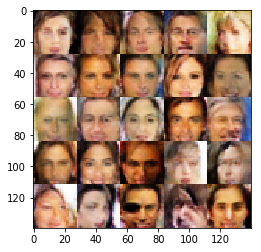

Epoch 1/1... Discriminator Loss: 0.8388... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.4991
Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 1.4246
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 2.3571
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.4586
Epoch 1/1... Discriminator Loss: 0.8748... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 0.6428... Generator Loss: 1.6365
Epoch 1/1... Discriminator Loss: 0.8703... Generator Loss: 0.9110
Epoch 1/1... Discriminator Loss: 0.8280... Generator Loss: 0.9056


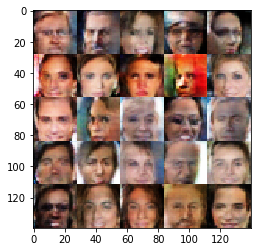

Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 0.9124
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 0.5377
Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 1.0190
Epoch 1/1... Discriminator Loss: 0.7651... Generator Loss: 1.8377
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 1.8838


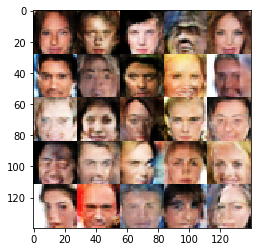

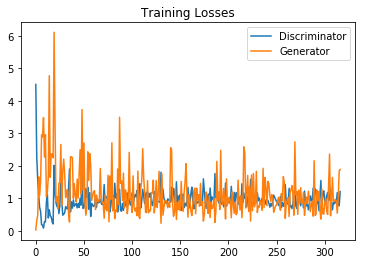

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 5e-4
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.